In [1]:

import numpy as np, pandas as pd
from shapely import *
import sys
sys.path.append('/Users/spaul/pcbflow/') 
from pcbflow import *
from pcbflow.route import Route
#skidl requires imp (https://integrativemodeling.org/)
from skidl import *
import os

# to view the pdf in the jupyter notebook (without having to switch back and forth with another application),
# use the "wand" package, which in turn requires another library called imagemagick.
#!pip install wand
#!pip install imagemagick
from wand.image import Image as WImage
#import beampipe_parameters

In [2]:

import os
path = "mypcb"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [3]:
def hxrt(A):
    return np.sqrt(A/(3*np.sqrt(3)/2))

In [373]:
from pcbflow import *

def make_board(layer, side):
    df=pd.read_csv(f"insert_layout/PCB_edges_{layer}{side}.csv")
    
    
    
    x=-df.x*10
    y=df.y*10
    #print(x,y)
    height=max(y)-min(y)
    width=max(x)-min(x)
    brd = Board((width, height))
    #standard sized vias
    #brd.drc.via_drill = 0.3
    #brd.drc.via_annular_ring = 0.15
    
    #small vias
    brd.drc.via_drill = 0.1
    brd.drc.via_annular_ring = 0.05
    
    #brd.add_outline()
    offset=[np.min(x), np.min(y)]
    x-=np.min(x)
    y-=np.min(y)
    brd.layers["GML"].lines.append(LinearRing(zip(x,y)))
    brd.add_inner_copper_layer(4)
    #help(brd)
    brd.body()
    
    return brd, offset
# fill the top and bottom copper layers and merge nets named "GND"
#brd.fill_layer("GTL", "GND")
#brd.fill_layer("GBL", "GND")

# save the PCB asset files
brd,offset = make_board(1,"L")
brd.save("test_outline")

Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...


In [374]:
def add_documentation(brd, layer, side, SiPM="S14160-1315PS"):
    df=pd.read_csv(f"insert_layout/SiPM_positions_{layer}{side}.csv")
    s=\
f"""CALI PCB board {side}{layer}
minimum space between channels={brd.drc.channel():.4f} mm
SiPM used={SiPM}
# of cells={len(df)}
cell side length={hxrt(df.area[0]):.2f} cm
cell area={df.area[0]:.1f} cm2"""
    #s="hi"
    #print(len(s.split("\n")))
    for i, line in enumerate(s.split("\n")):
        #print(i)
        brd.add_text((brd.size[0]-30,brd.size[1]-5-i*1.5), line,layer='GBS', side='bottom', justify='right')

In [375]:
def outline_polygon(brd, xy):
    dc=brd.DC(xy[0])
    dc.push()
    dc.newpath()
    olddir=90
    for j in range(len(xy)-1):
        #help(dc.goto)    
        t=xy[j+1][1]-xy[j][1],xy[j+1][0]-xy[j][0]
        newdir=180/np.pi*np.arctan2(*t)
        dc.left(newdir-olddir)
        dc.forward(np.hypot(xy[j+1][1]-xy[j][1],xy[j+1][0]-xy[j][0]))
        olddir=newdir
    dc.silk('top')
    dc.pop()

In [376]:
def add_mill_marks(brd, layer, side, additional_layers):
    print("adding mill marks")
    for lay in additional_layers:
        df=pd.read_csv(f"insert_layout/PCB_edges_{lay}{side}.csv")
        x=-df.x*10
        y=df.y*10
        
        x-=np.min(x)
        y-=np.min(y)
        #print("mill mark outline", x,y)
        outline_polygon(brd,list(zip(x,y)))

In [521]:
#adds the SiPMs plus associated electronics and traces.  
def add_SiPMs(brd, layer, side, offset):
    df=pd.read_csv(f"insert_layout/SiPM_positions_{layer}{side}.csv")
    x=-df.x*10-offset[0]
    y=df.y*10-offset[1]
    
    df["x_mm"]=x
    df["y_mm"]=y
    
    r=hxrt(df.area[0]*100)
    #create a hexagon
    phi=np.linspace(0, 2*np.pi, 7)
    
    #add these to the dict of layer names
    import pcbflow.kicad as kicad
    kicad.KI_LAYER_DICT["F.CrtYd"]="GTO"
    kicad.KI_LAYER_DICT['"F.SilkS"']=kicad.KI_LAYER_DICT['F.SilkS']
    kicad.KI_LAYER_DICT['"F.Fab"']= kicad.KI_LAYER_DICT['F.Fab']
    kicad.KI_LAYER_DICT['"F.Cu"']= kicad.KI_LAYER_DICT['F.Cu']
    SiPMs=[]
    for xi,yi in zip(x,y):
        #brd.add_text((xi,yi), "SiPM")
        outline_polygon(brd, list(zip(xi+np.cos(phi)*r,yi+np.sin(phi)*r)))
        #brd.layers["GTS"].lines.append(LinearRing(zip(xi+np.cos(phi)*ri,yi+np.sin(phi)*r)))
        SiPM=KiCadPart(brd.DC((xi, yi)), libraryfile="footprints/SiPM_test_named.kicad_mod")
        SiPMs.append(SiPM)
    
    #now make traces towards the inner side for all of the SiPMs
    gap=brd.drc.channel()
    for row in list(set(df.row)):
        for i in range(len(df)):
            if df.row[i]!=row:
                continue
            if side=="L":
                #SiPM cathode
                deltaY=SiPMs[i].pad('"SiPM_C"').xy[1]-SiPMs[i].pad('"GND"').xy[1]+2*gap
                deltaX=max(df.query(f"row=={row}").x_mm)-SiPMs[i].pad('"SiPM_C"').xy[0]+2*gap+3.0
                c=df.col[i]//2
                SiPMs[i].pad('"SiPM_C"').set_layer("GP2").left(90).forward(2*gap).left(90)\
                            .forward(deltaY+(c)*gap).left(90).forward(deltaX).wire()

                #SiPM anode
                deltaY=SiPMs[i].pad('"SiPM_A"').xy[1]-SiPMs[i].pad('"GND"').xy[1]+2*gap
                deltaX=max(df.query(f"row=={row}").x_mm)-SiPMs[i].pad('"SiPM_A"').xy[0]+2*gap+3.0
                SiPMs[i].pad('"SiPM_A"').set_layer("GP3").left(90).forward(2*gap).left(90)\
                            .forward(deltaY+(c)*gap).left(90).forward(deltaX).wire()

            else:
                #SiPM cathode
                deltaY=SiPMs[i].pad('"SiPM_C"').xy[1]-SiPMs[i].pad('"GND"').xy[1]+2*gap
                deltaX=SiPMs[i].pad('"SiPM_C"').xy[0]-min(df.query(f"row=={row}").x_mm)-1.0+6.0
                c=(max(df.query(f"row=={row}").col)-df.col[i])//2
                SiPMs[i].pad('"SiPM_C"').set_layer("GP2").left(90).forward(1.0).left(90)\
                            .forward(deltaY+(c)*gap).right(90).forward(deltaX).wire()

                #SiPM anode
                deltaY=SiPMs[i].pad('"SiPM_A"').xy[1]-SiPMs[i].pad('"GND"').xy[1]+2*gap
                deltaX=SiPMs[i].pad('"SiPM_A"').xy[0]-min(df.query(f"row=={row}").x_mm)-1.0+6.0
                SiPMs[i].pad('"SiPM_A"').set_layer("GP3").left(90).forward(1.0).left(90)\
                            .forward(deltaY+(c)*gap).right(90).forward(deltaX).wire()

            # have the traces connecting the capacitor to the GND all connect to one another
            # as one another.  Must be higher than the LED's vias
            deltaX=df.x_mm[i]-SiPMs[i].pad('"GND"').xy[0]
            deltaY=SiPMs[i].pad('"LED_C"').xy[1]-SiPMs[i].pad('"GND"').xy[1]+1.5
            SiPMs[i].pad('"GND"').through().left(90).forward(deltaX).right(90)\
                        .forward(deltaY).wire()
            
            if side=="L" and df.col[i]==min(df.query(f"row=={row}").col):
                xGND=10
                a=SiPMs[i].pad('"GND"').copy().right(90).forward(SiPMs[i].pad('"GND"').xy[0]-xGND)
                a.wire()
                if row==min(df.row):
                    a.left(90).forward(max(df.y_mm)-min(df.y_mm)).wire()
                if df.col[i]==min(df.query(f"row=={max(df.row)}").col) and df.row[i]==max(df.row):
                    GND=SiPMs[i].pad('"GND"')
                    LED_A=SiPMs[i].pad('"LED_A"')
            if side=="R" and df.col[i]==max(df.query(f"row=={row}").col):
                xGND=brd.size[0]-10
                a=SiPMs[i].pad('"GND"').copy().left(90).forward(xGND-SiPMs[i].pad('"GND"').xy[0]).wire()
                if row==min(df.row):
                    a.right(90).forward(max(df.y_mm)-min(df.y_mm)).wire()
            if side=="R" and df.col[i]==min(df.query(f"row=={min(df.row)}").col) and df.row[i]==min(df.row):
                LED_A=SiPMs[i].pad('"LED_A"')
            if side=="R" and df.col[i]==min(df.query(f"row=={max(df.row)}").col) and df.row[i]==max(df.row):
                GND=SiPMs[i].pad('"GND"')
            
    #now connect the LEDs in series with one another
    for i in range(len(SiPMs)):
        if df.col[i]!=max(df.query(f"row=={df.row[i]}").col):
            for j in range(len(SiPMs)):
                if df.col[i]==df.col[j]-2 and df.row[i]==df.row[j]:
                    SiPMs[i].pad('"LED_C"').through().meet(SiPMs[j].pad('"LED_A"'))            
        #upper left of a right board or lower left of a left board:  connects to ground
        elif df.row[i]==max(df.row) and side=="R" or df.row[i]==min(df.row) and side=="L": 
            SiPMs[i].pad('"LED_C"').through().meet(SiPMs[i].pad('"GND"'))
        #leftmost in its row, snake around to the row above or below, depending on which side board it is
        elif side=="L": 
            for j in range(len(SiPMs)):
                if df.col[j]==min(df.query(f"row=={df.row[j]}").col) and df.row[i]-1==df.row[j]:
                    deltaY=SiPMs[i].pad('"LED_C"').xy[1]-SiPMs[j].pad('"LED_A"').xy[1]
                    deltaX=SiPMs[j].pad('"LED_A"').xy[0]-SiPMs[i].pad('"LED_C"').xy[0]
                    SiPMs[i].pad('"LED_C"').through().right(90).forward(3.5).right(90)\
                    .forward(deltaY-2).right(90).forward(3.5+deltaX).meet(SiPMs[j].pad('"LED_A"'))
        elif side=="R":
            for j in range(len(SiPMs)):
                if df.col[j]==min(df.query(f"row=={df.row[j]}").col) and df.row[i]+1==df.row[j]:
                    deltaY=SiPMs[i].pad('"LED_C"').xy[1]-SiPMs[j].pad('"LED_A"').xy[1]
                    deltaX=-SiPMs[j].pad('"LED_A"').xy[0]+SiPMs[i].pad('"LED_C"').xy[0]
                    SiPMs[i].pad('"LED_C"').through().right(90).forward(0.5).left(90)\
                    .forward(2).right(90).forward(0.5+deltaX).meet(SiPMs[j].pad('"LED_A"')) 
    #now for the last anode, connect it around to the top.  
    LED_A.through().left(90).forward(xGND+gap-LED_A.xy[0]).right(90)\
        .forward(GND.xy[1]+gap-LED_A.xy[1]).wire().right(90).forward(brd.size[0]-5-min(df.x_mm)).wire()
    return SiPMs, GND, LED_A
#test this method
brd,offset = make_board(60,"R")
add_mill_marks(brd, 60, "R", [5, 9, 13, 17])
SiPMs, GND, LED_A=add_SiPMs(brd, 60, "R", offset)
add_documentation(brd, 60, "R")
brd.save("test_sipm")
print('saved')

adding mill marks
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
saved


In [527]:
def add_connectors(brd, layer, side, offset, SiPMs, GND, LED_A, connector_positions):
    df=pd.read_csv(f"insert_layout/SiPM_positions_{layer}{side}.csv")
    x=-df.x*10-offset[0]
    y=df.y*10-offset[1]
    
    df["x_mm"]=x
    df["y_mm"]=y
    
    gap=brd.drc.channel()
    
    nrows=len(set(df.row))
    # repeat this process with only the top group of rows 
    # and then with the bottom ones
    for UD in 1, -1:
        
        
        median_row=np.median(list(set(df.row)))
        selection=(df.row>median_row) if UD==1 else (df.row<=median_row)
        rows=list(sorted(list(set(df.row[selection]))))
        #print(rows)
        if UD==-1: #lower side
            rows=list(reversed(rows))
        #print(rows)
        
        if side=="L":
            yconn=brd.size[1]/2+UD*252.5
            xconn=brd.size[0]-9
            connector_name="footprints/Samtec_HSEC8-140-01-X-DV-A_2x40_P0.8mm_Pol22_Socket_AlignmentPins.kicad_mod"
            connector=KiCadPart(brd.DC((xconn, yconn),90), libraryfile=connector_name)
            #ground and LEDs
            if UD==1:
                connector.pads[0].left(90).forward(1).through().forward(GND.xy[1]-connector.pads[0].xy[1]).meet(GND)
                if LED_A.xy[1]-connector.pads[1].xy[1]>0:
                    connector.pads[1].left(90).forward(LED_A.xy[1]-connector.pads[1].xy[1]).left(90).forward(10).through().meet(LED_A)
                else:
                    connector.pads[1].left(90).forward(1).through().forward(LED_A.xy[1]-connector.pads[1].xy[1]).meet(LED_A)
            #connector.fanout([pad.name for pad in connector.pads[2 if UD==1 else 0:]], 1.6)
        if side=="R":
            yconn=brd.size[1]/2+UD*252.5
            xconn=9
            if layer<=20:
                connector_name="footprints/Samtec_HSEC8-170-01-X-DV_2x70_P0.8mm_Pol32_Socket.kicad_mod"
            else:
                connector_name="footprints/Samtec_HSEC8-140-01-X-DV-A_2x40_P0.8mm_Pol22_Socket_AlignmentPins.kicad_mod"
            connector=KiCadPart(brd.DC((xconn, yconn),90), libraryfile=connector_name)
            #ground and LEDs
            if UD==1:
                connector.pads[0].left(90).forward(1).through().forward(GND.xy[1]-connector.pads[0].xy[1]).meet(GND)
                if LED_A.xy[1]-connector.pads[1].xy[1]>0:
                    connector.pads[1].left(90).forward(LED_A.xy[1]-connector.pads[1].xy[1]).right(90).forward(10).through().meet(LED_A)
                else:
                    connector.pads[1].left(90).forward(1).through().forward(LED_A.xy[1]-connector.pads[1].xy[1]).meet(LED_A)
            #connector.fanout([pad.name for pad in connector.pads[2 if UD==1 else 0:]], 1.6)
        
        #now pair every SiPM trace with a connector trace
        SiPMs_to_connectors={}
        connectors_to_SiPMs={}
        for i, pad in enumerate(connector.pads[2 if UD==1 else 0:]):
            if i %2==1:
                #cathode
                #find the SiPM with the uppermost cathode trace that isn't already connected
                ymax_not_connected=-10
                j_at_ymax=-1
                for j,SiPM in enumerate(SiPMs):
                    if selection[j]==False:
                        continue
                    if SiPM.pad('"SiPM_C"') not in SiPMs_to_connectors and SiPM.pad('"SiPM_C"').xy[1]>ymax_not_connected:
                        ymax_not_connected=SiPM.pad('"SiPM_C"').xy[1]
                        j_at_ymax=j
                if j_at_ymax !=-1:
                    SiPMs_to_connectors[SiPMs[j_at_ymax].pad('"SiPM_C"')]=pad
                    connectors_to_SiPMs[pad]=SiPMs[j_at_ymax].pad('"SiPM_C"')
            else:
                #anode
                #find the SiPM with the uppermost anode trace that isn't already connected
                ymax_not_connected=-10
                j_at_ymax=-1
                for j,SiPM in enumerate(SiPMs):
                    if selection[j]==False:
                        continue
                    if SiPM.pad('"SiPM_A"') not in SiPMs_to_connectors and SiPM.pad('"SiPM_A"').xy[1]>ymax_not_connected:
                        ymax_not_connected=SiPM.pad('"SiPM_A"').xy[1]
                        j_at_ymax=j
                if j_at_ymax !=-1:
                    SiPMs_to_connectors[SiPMs[j_at_ymax].pad('"SiPM_A"')]=pad
                    connectors_to_SiPMs[pad]=SiPMs[j_at_ymax].pad('"SiPM_A"')
        
        
        # now bunch together the traces from different rows:
        for m in range(1, len(rows)):
            
                            
            for i,row in enumerate(rows[:-m]):
                indices_in_bunch=[]
                for j in range(len(SiPMs)):
                    if df.row[j]==row:
                        indices_in_bunch.append(j)
                #find the y of the uppermost trace in this row
                y_this_row=(min if UD==-1 else max)([SiPMs[l].pad('"SiPM_C"').xy[1] for l in indices_in_bunch])
                for j in indices_in_bunch:
                    if side=="R":
                        dy_to_connector=abs(SiPMs[j].pad('"SiPM_C"').xy[1]-SiPMs_to_connectors[SiPMs[j].pad('"SiPM_C"')].xy[1])
                        if dy_to_connector<0.01:
                            continue
                        deltaX=0
                        deltaY=None
                        y_next_row=None
                        for k in range(len(SiPMs)):
                            dx=SiPMs[j].pad('"SiPM_C"').xy[0]-SiPMs[k].pad('"SiPM_C"').xy[0]
                            #if dx<=0:
                            #    continue
                            if df.row[k] not in rows[i+1:]:
                                continue
                            if (df.row[k]-df.row[j])*UD<=0:
                                continue
                            if df.row[k]!= rows[i+1]:
                                continue

                            if UD>0:
                                y=SiPMs[k].pad('"SiPM_C"').xy[1]
                                if y_next_row is None or y<y_next_row:
                                    y_next_row=y
                                    deltaY=abs(y_this_row-y_next_row)-gap
                                    deltaX=dx
                            else:
                                y=SiPMs[k].pad('"SiPM_C"').xy[1]
                                if y_next_row is None or y>y_next_row:
                                    y_next_row=y
                                    deltaY=abs(y_this_row-y_next_row)-gap
                                    deltaX=dx
                            
                            
                        if deltaX<0:
                            deltaX=0
                        if deltaY is None:
                            deltaY=dy_to_connector
                        #don't overshoot
                        if deltaY<0:
                            deltaY=0
                        if deltaY>dy_to_connector:
                            deltaY=dy_to_connector
                        #print("deltaY",deltaY)
                        #print("y",y)
                        if UD==-1:
                            extension=gap*((df.col[j]-min(df.col[df.row==row]))//2)
                        elif UD==1:
                            extension=gap*((max(df.col[df.row==row])-df.col[j])//2)
                        
                        #determine how far to extend further
                        aa=len(df.query(f"row=={rows[i]}"))
                        if deltaX!=0:
                            for AC in "AC":
                                SiPMs[j].pad(f'"SiPM_{AC}"').forward(deltaX+extension).right(UD*90).forward(deltaY).left(UD*90).wire().forward(aa*gap-extension).wire()
                        else:
                            for AC in "AC":
                                extend_to_connector=True
                                #now check if it's ok to extend the rest of the way to the connector height
                                for k in range(len(SiPMs)):
                                    if k == j: 
                                        continue
                                    if not selection[k]:
                                        continue
                                    if UD*(df.row[k]-df.row[j])<=0:
                                        continue
                                    if SiPMs[k].pad(f'"SiPM_{AC}"').xy[0]>SiPMs[j].pad(f'"SiPM_{AC}"').xy[0]+gap:
                                        continue
                                    extend_to_connector=False
                                
                                if extend_to_connector:
                                    deltaY=dy_to_connector
                                SiPMs[j].pad(f'"SiPM_{AC}"').forward(deltaX+extension).right(UD*90).forward(deltaY).left(UD*90).wire().forward(aa*gap-extension).wire()
                        
                        
                    if side=="L":
                        dy_to_connector=abs(SiPMs[j].pad('"SiPM_C"').xy[1]-SiPMs_to_connectors[SiPMs[j].pad('"SiPM_C"')].xy[1])
                        if dy_to_connector<0.01:
                            continue
                        deltaX=0
                        deltaY=None
                        y_next_row=None
                        for k in range(len(SiPMs)):
                            dx=SiPMs[k].pad('"SiPM_C"').xy[0]-SiPMs[j].pad('"SiPM_C"').xy[0]
                            #if dx<=0:
                            #    continue
                            if df.row[k] not in rows[i+1:]:
                                continue
                            if (df.row[k]-df.row[j])*UD<=0:
                                continue
                            if df.row[k]!= rows[i+1]:
                                continue

                            if UD>0:
                                y=SiPMs[k].pad('"SiPM_C"').xy[1]
                                if y_next_row is None or y<y_next_row:
                                    y_next_row=y
                                    deltaY=abs(y_this_row-y_next_row)-gap
                                    deltaX=dx
                            else:
                                y=SiPMs[k].pad('"SiPM_C"').xy[1]
                                if y_next_row is None or y>y_next_row:
                                    y_next_row=y
                                    deltaY=abs(y_this_row-y_next_row)-gap
                                    deltaX=dx
                            
                            
                        if deltaX<0:
                            deltaX=0
                        if deltaY is None:
                            deltaY=dy_to_connector
                        #don't overshoot
                        if deltaY<0:
                            deltaY=0
                        if deltaY>dy_to_connector:
                            deltaY=dy_to_connector
                        #print("deltaY",deltaY)
                        #print("y",y)
                        
                        if UD==1:
                            extension=gap*((df.col[j]-min(df.col[df.row==row]))//2)
                        elif UD==-1:
                            extension=gap*((max(df.col[df.row==row])-df.col[j])//2)
                        #determine how far to extend further
                        aa=len(df.query(f"row=={rows[i]}"))
                        if deltaX!=0:
                            for AC in "AC":
                                SiPMs[j].pad(f'"SiPM_{AC}"').forward(deltaX+extension).left(UD*90).forward(deltaY).right(UD*90).wire().forward(aa*gap-extension).wire()
                        else:
                            for AC in "AC":
                                extend_to_connector=True
                                #now check if it's ok to extend the rest of the way to the connector height
                                for k in range(len(SiPMs)):
                                    if k == j: 
                                        continue
                                    if not selection[k]:
                                        continue
                                    if UD*(df.row[k]-df.row[j])<=0:
                                        continue
                                    if SiPMs[k].pad(f'"SiPM_{AC}"').xy[0]<SiPMs[j].pad(f'"SiPM_{AC}"').xy[0]-gap:
                                        continue
                                    extend_to_connector=False
                                
                                if extend_to_connector:
                                    deltaY=dy_to_connector
                                SiPMs[j].pad(f'"SiPM_{AC}"').forward(deltaX+extension).left(UD*90).forward(deltaY).right(UD*90).wire().forward(aa*gap-extension).wire()
                        
        
        #next connect every pad from the connector to its anode or cathode trace
        for i, pad in enumerate(connector.pads[2 if UD==1 else 0:]):
            if i %2==1:
                #cathode
                if pad in connectors_to_SiPMs:
                    SiPM_C=connectors_to_SiPMs[pad]
                    if side == "L":
                        pad.forward(1.6).through().set_layer("GP2").left(90).forward(0.4).left(90).forward(7).left(90).forward(0.4).wire()
                    elif side=="R":
                        pad.forward(1.6).through().set_layer("GP2").wire()
                    SiPM_C.meet(pad)
                    
            else:
                #anode
                if pad in connectors_to_SiPMs:
                    SiPM_A=connectors_to_SiPMs[pad]
                    if side == "L":
                        pad.right(180).forward(1.6).through().set_layer("GP3").wire()
                    elif side == "R":
                        pad.right(180).forward(1.6).through().set_layer("GP3").right(90).forward(0.4).right(90).forward(7).right(90).forward(0.4).wire()
                    SiPM_A.meet(pad)

                
                
            
# test this method
layer=17
brdid=(layer,"L")
brd,offset = make_board(*brdid)
#add_mill_marks(brd,*brdid, [layer+4, layer+8, layer+12, layer+16])
#add_mill_marks(brd,*brdid, [60])
SiPMs,GND, LED_A=add_SiPMs(brd, *brdid, offset)
add_documentation(brd, *brdid)
connector_positions=[]
add_connectors(brd, *brdid, offset, SiPMs, GND, LED_A, connector_positions)
brd.save("test_sipm")
print('saved')

Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
saved


In [418]:
# def add_connectors(brd, layer, side, offset, SiPMs, GND, LED_A, connector_positions):
#     df=pd.read_csv(f"insert_layout/SiPM_positions_{layer}{side}.csv")
#     x=-df.x*10-offset[0]
#     y=df.y*10-offset[1]
    
#     df["x_mm"]=x
#     df["y_mm"]=y
    
#     gap=brd.drc.channel()
    
#     nrows=len(set(df.row))
#     # repeat this process with only the top group of rows 
#     # and then with the bottom ones
#     for UD in 1, -1:
#         median_row=np.median(list(set(df.row)))
#         selection=(df.row>median_row) if UD==1 else (df.row<=median_row)
#         rows=list(sorted(list(set(df.row[selection]))))
#         #print(rows)
#         if UD==-1: #lower side
#             rows=list(reversed(rows))
#         #print(rows)
        
#         # now bunch together the traces from different rows:
#         for m in range(1, len(rows)):
#             # make sure that the traces of all rows in the bottom (top) half extend at least as 
#             # far as the one just above (below) it.  
#             for i,row in enumerate(rows):
#                 #iterate over SiPMs in this row
#                 for j in range(len(SiPMs)):
#                     if df.row[j]!= row or (df.col[j] != max(df.col[df.row==row]) and side=="L") \
#                                 or (df.col[j] != min(df.col[df.row==row]) and side=="R") :
#                         continue
#                     #print(row, df.row[j],df.col[j])

#                     ntrace=len(df.query(f"row=={row}"))*2

#                     #and those in the next row outward vertically
#                     for k in range(len(SiPMs)):
#                         if i==len(rows)-1 or df.row[k]!= rows[i+1]:
#                             continue
#                         if side=="L":
#                             if SiPMs[k].pad('"SiPM_C"').xy[0]<SiPMs[j].pad('"SiPM_C"').xy[0]:
#                                 extension=SiPMs[j].pad('"SiPM_C"').xy[0]-SiPMs[k].pad('"SiPM_C"').xy[0]
#                                 SiPMs[k].pad('"SiPM_C"').forward(extension).wire()
#                                 SiPMs[k].pad('"SiPM_A"').forward(extension).wire()
#                                 #print("extending", df.row[k], df.col[k], extension)
#                         if side=="R":
#                             if SiPMs[k].pad('"SiPM_C"').xy[0]>SiPMs[j].pad('"SiPM_C"').xy[0]:
#                                 extension=SiPMs[k].pad('"SiPM_C"').xy[0]-SiPMs[j].pad('"SiPM_C"').xy[0]
#                                 SiPMs[k].pad('"SiPM_C"').forward(extension).wire()
#                                 SiPMs[k].pad('"SiPM_A"').forward(extension).wire()
#                                 #print("extending", df.row[k], df.col[k], extension)
                            
        
#             for i,row in enumerate(rows[:-m]):
#                 indices_in_bunch=[]
#                 for j in range(len(SiPMs)):
#                     if df.row[j]==row:
#                         indices_in_bunch.append(j)
#                 #find the y of the uppermost trace in this row
#                 y_this_row=(min if UD==-1 else max)([SiPMs[l].pad('"SiPM_C"').xy[1] for l in indices_in_bunch])
#                 for j in indices_in_bunch:
#                     if side=="R":
#                         #find where the next row's traces are
#                         y_next_row=None
#                         for k in range(len(SiPMs)):
#                             #find the leftmost SiPM in the next row
#                             if df.row[k]!= rows[i+1]:
#                                 continue
#                             if df.col[k]!=max(df.col[df.row==rows[i+1]]) and UD==-1:
#                                 continue
#                             deltaX=SiPMs[j].pad('"SiPM_C"').xy[0]-SiPMs[k].pad('"SiPM_C"').xy[0]
#                             if UD>0:
#                                 y=SiPMs[k].pad('"SiPM_C"').xy[1]
#                                 if y_next_row is None or y<y_next_row:
#                                     y_next_row=y
#                             else:
#                                 y=SiPMs[k].pad('"SiPM_C"').xy[1]
#                                 if y_next_row is None or y>y_next_row:
#                                     y_next_row=y
#                             deltaY=abs(y_this_row-y_next_row)-gap
#                             break
#                         #print("deltaY",deltaY)
#                         #print("y",y)
#                         if UD==-1:
#                             extension=gap*((df.col[j]-min(df.col[df.row==row]))//2)
#                         elif UD==1:
#                             extension=gap*((max(df.col[df.row==row])-df.col[j])//2)
#                         #determine how far to extend further
#                         aa=len(df.query(f"row=={rows[i]}"))
#                         for AC in "AC":
#                             SiPMs[j].pad(f'"SiPM_{AC}"').forward(deltaX+extension).right(UD*90).forward(deltaY).left(UD*90).forward(aa*gap-extension).wire()
                        
#                     if side=="L":
#                         y_next_row=None
#                         for k in range(len(SiPMs)):
#                             if df.row[k]!= rows[i+1]:
#                                 continue
#                             #if df.col[k]!=min(df.col[df.row==rows[i+1]]) and UD==-1:
#                             #    continue
#                             deltaX=SiPMs[k].pad('"SiPM_C"').xy[0]-SiPMs[j].pad('"SiPM_C"').xy[0]
#                             if UD>0:
#                                 y=SiPMs[k].pad('"SiPM_C"').xy[1]
#                                 if y_next_row is None or y<y_next_row:
#                                     y_next_row=y
#                             else:
#                                 y=SiPMs[k].pad('"SiPM_C"').xy[1]
#                                 if y_next_row is None or y>y_next_row:
#                                     y_next_row=y
#                             deltaY=abs(y_this_row-y_next_row)-gap
#                         #print("deltaY",deltaY)
#                         #print("y",y)
#                         if UD==1:
#                             extension=gap*((df.col[j]-min(df.col[df.row==row]))//2)
#                         elif UD==-1:
#                             extension=gap*((max(df.col[df.row==row])-df.col[j])//2)
#                         #determine how far to extend further
#                         aa=len(df.query(f"row=={rows[i]}"))
#                         for AC in "AC":
#                             SiPMs[j].pad(f'"SiPM_{AC}"').forward(deltaX+extension).left(UD*90).forward(deltaY).right(UD*90).wire().forward(aa*gap-extension).wire()
        
#         if side=="L":
#             yconn=brd.size[1]/2+UD*252.5
#             xconn=brd.size[0]-9
#             connector_name="footprints/Samtec_HSEC8-140-01-X-DV-A_2x40_P0.8mm_Pol22_Socket_AlignmentPins.kicad_mod"
#             connector=KiCadPart(brd.DC((xconn, yconn),90), libraryfile=connector_name)
#             #ground and LEDs
#             if UD==1:
#                 connector.pads[0].left(90).forward(1).through().forward(GND.xy[1]-connector.pads[0].xy[1]).meet(GND)
#                 connector.pads[1].left(90).forward(1).through().forward(LED_A.xy[1]-connector.pads[1].xy[1]).meet(LED_A)
#             #connector.fanout([pad.name for pad in connector.pads[2 if UD==1 else 0:]], 1.6)
#         if side=="R":
#             yconn=brd.size[1]/2+UD*252.5
#             xconn=9
#             connector_name="footprints/Samtec_HSEC8-140-01-X-DV-A_2x40_P0.8mm_Pol22_Socket_AlignmentPins.kicad_mod"
#             connector=KiCadPart(brd.DC((xconn, yconn),-90), libraryfile=connector_name)
#             #ground and LEDs
#             if UD==1:
#                 connector.pads[0].left(90).forward(1).through().forward(GND.xy[1]-connector.pads[0].xy[1]).meet(GND)
#                 connector.pads[1].left(90).forward(1).through().forward(LED_A.xy[1]-connector.pads[1].xy[1]).meet(LED_A)
#             #connector.fanout([pad.name for pad in connector.pads[2 if UD==1 else 0:]], 1.6)
        
        
#         anodes_connected=[]
#         cathodes_connected=[]
#         for i, pad in enumerate(connector.pads[2 if UD==1 else 0:]):
#             if i %2==1:
#                 #cathode
#                 #find the SiPM with the uppermost cathode trace that isn't already connected
#                 ymax_not_connected=-10
#                 j_at_ymax=-1
#                 for j,SiPM in enumerate(SiPMs):
#                     if selection[j]==False:
#                         continue
#                     if j not in cathodes_connected and SiPM.pad('"SiPM_C"').xy[1]>ymax_not_connected:
#                         ymax_not_connected=SiPM.pad('"SiPM_C"').xy[1]
#                         j_at_ymax=j
#                 if j_at_ymax !=-1:
#                     pad.forward(1.6).through().set_layer("GP2").left(90).forward(0.4).left(90).forward(7).wire()
#                     #pad.meet(SiPMs[j_at_ymax].pad('"SiPM_C"'))
#                     a=1.5*gap*abs((SiPMs[j_at_ymax].pad('"SiPM_C"').xy[0]-pad.xy[0])/(SiPMs[j_at_ymax].pad('"SiPM_C"').xy[1]-pad.xy[1]))
#                     SiPMs[j_at_ymax].pad('"SiPM_C"').forward(a).meet(pad)
#                     cathodes_connected.append(j_at_ymax)
#             else:
#                 #pass
#                 #anode
                
#                 #find the SiPM with the uppermost anode trace that isn't already connected
#                 ymax_not_connected=-10
#                 j_at_ymax=-1
#                 for j,SiPM in enumerate(SiPMs):
#                     if selection[j]==False:
#                         continue
#                     if j not in anodes_connected and SiPM.pad('"SiPM_A"').xy[1]>ymax_not_connected:
#                         ymax_not_connected=SiPM.pad('"SiPM_A"').xy[1]
#                         j_at_ymax=j
#                 if j_at_ymax !=-1:
#                     pad.right(180).forward(1.6).through().set_layer("GP3")
#                     a=1.5*gap*abs((SiPMs[j_at_ymax].pad('"SiPM_A"').xy[0]-pad.xy[0])/(SiPMs[j_at_ymax].pad('"SiPM_A"').xy[1]-pad.xy[1]))
#                     SiPMs[j_at_ymax].pad('"SiPM_A"').forward(a).meet(pad)
#                     anodes_connected.append(j_at_ymax)
#         #print(rows)
        
# #         for row in rows:
# #             if row>np.median(row)
# #             #determine if the traces go to the upper connector or the lower one
# #             UD = +1 if  else -1
# #             for i in range(len(df[selection])):
# #                 if df.row[i]!= row:
# #                     continue
# #                 for j in range(len(df)):
# #                     if df.row[j]==row+UD:
# #                         if side=="L" and df.row[i]==
                
                
            
# # test this method
# layer=1
# brdid=(layer,"L")
# brd,offset = make_board(*brdid)
# add_mill_marks(brd,*brdid, [layer+4, layer+8, layer+12, layer+16])
# #add_mill_marks(brd,*brdid, [60])
# SiPMs,GND, LED_A=add_SiPMs(brd, *brdid, offset)
# add_documentation(brd, *brdid)
# connector_positions=[]
# add_connectors(brd, *brdid, offset, SiPMs, GND, LED_A, connector_positions)
# brd.save("test_sipm")
# print('saved')

adding mill marks
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
saved


In [352]:
help(SiPMs[0].fanout)

Help on method fanout in module pcbflow.part:

fanout(nets=None, length=None, relative_to='outside') method of pcbflow.kicad.KiCadPart instance



In [219]:
for padname in '"SiPM_A" "SiPM_C" "LED_A" "LED_C"'.split():
    print(padname, SiPMs[0].pad(padname).xy)

"SiPM_A" (21.230000000000018, 24.499599999999948)
"SiPM_C" (21.230000000000018, 24.905999999999946)
"LED_A" (353.23, 35.77)
"LED_C" (349.13, 35.77)


In [277]:
[1,2][:2]

[1]

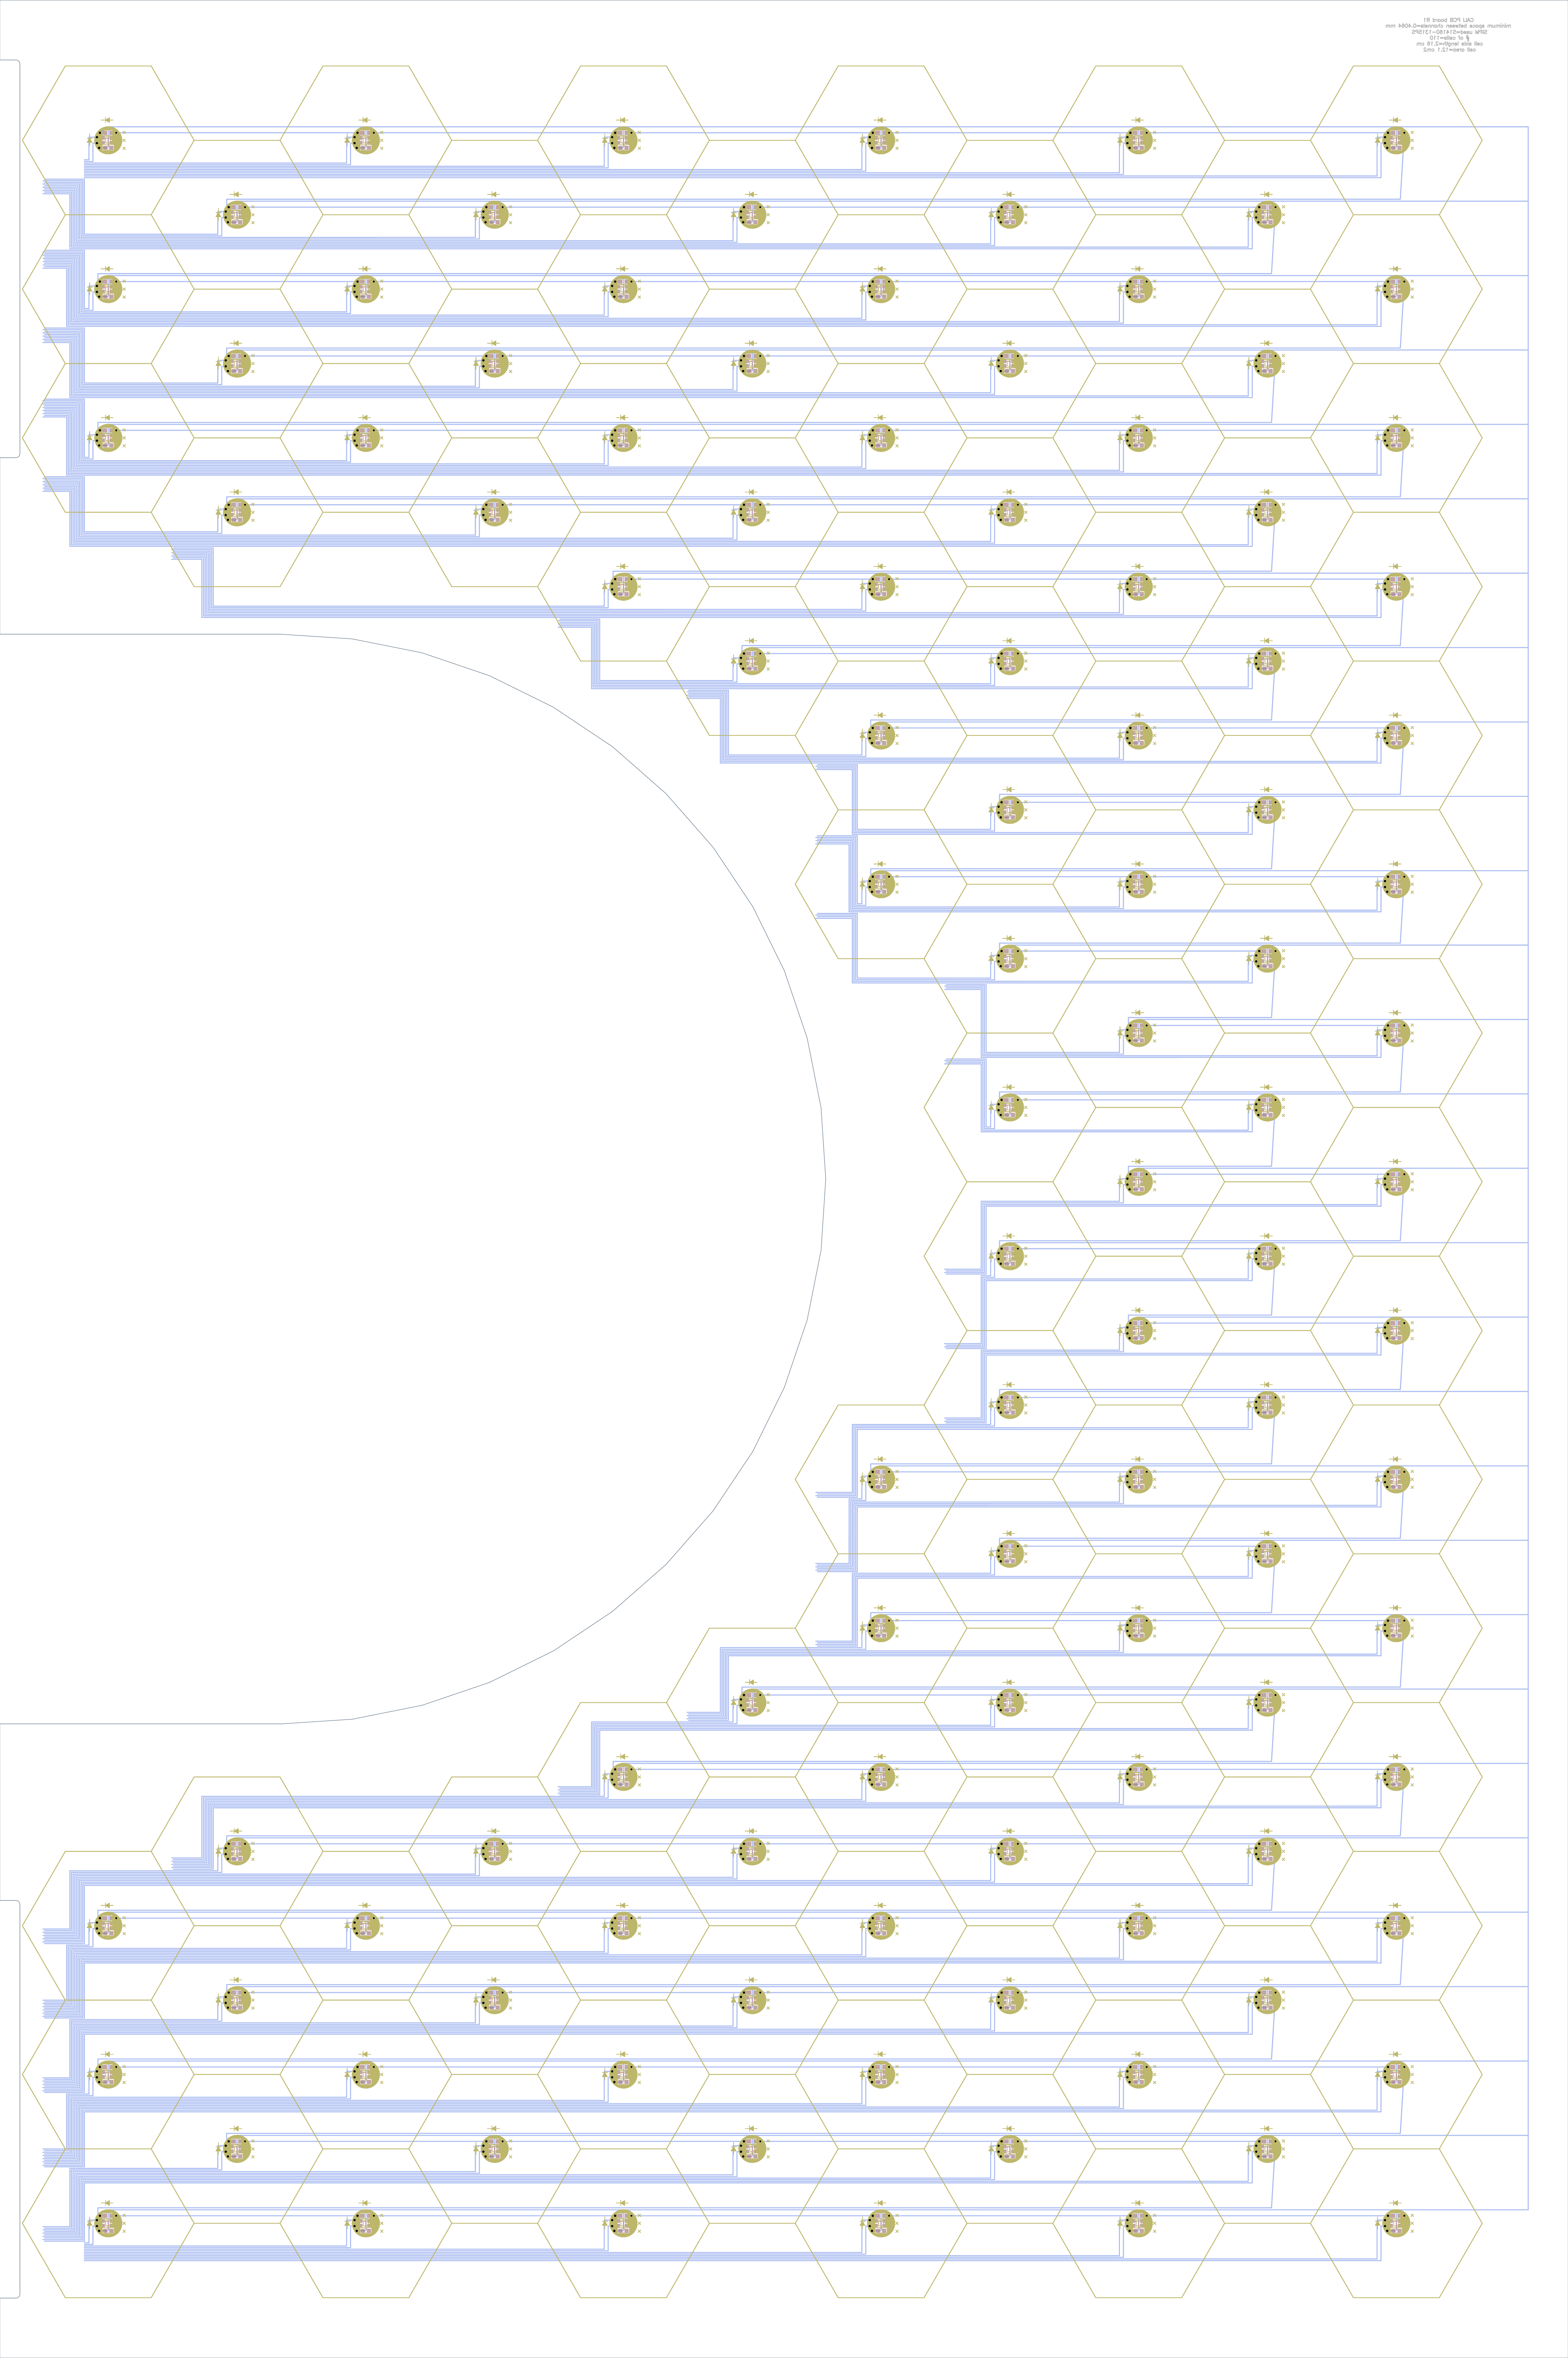

In [220]:

img = WImage(filename='test_sipm/test_sipm_preview_all.pdf')
img

In [221]:
#help(KiCadPart)
help(brd)

Help on Board in module pcbflow.board object:

class Board(builtins.object)
 |  Board(size=(80, 50))
 |  
 |  Methods defined here:
 |  
 |  DC(self, xy, d=0)
 |      Returns a drawing context from the current board.
 |      
 |      :param xy: x, y coordinate tuple
 |      :param d: d direction angle (deg)
 |      
 |      :returns: :obj:`Draw` drawing context object
 |  
 |  __init__(self, size=(80, 50))
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_bitmap(self, xy, fn, scale=None, side='top', layer=None, keepout_box=False, soldermask_box=False)
 |  
 |  add_drill(self, xy, diameter)
 |  
 |  add_hole(self, xy, diameter)
 |  
 |  add_inner_copper_layer(self, layer_count=1)
 |      Adds one or more copper layers between the top and bottom copper layers.
 |      
 |      :param layer_count : Specifies how many copper layers to insert
 |  
 |  add_keepout(self, top_left, bottom_right, layer)
 |  
 |  add_keepout_to_obj(self, obj, layer=None)
 |  
 |

In [9]:
help(brd.save)

Help on method save in module pcbflow.board:

save(basename, in_subdir=True, gerber=True, pdf=True, bom=True, centroids=True, povray=False, subdir=None) method of pcbflow.board.Board instance



In [222]:
help(SiPMs[0].pads[-1])

Help on Draw in module pcbflow.draw object:

class Draw(Turtle)
 |  Draw(board, xy, dir=0, name=None)
 |  
 |  Drawing context class
 |  
 |  Method resolution order:
 |      Draw
 |      Turtle
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, board, xy, dir=0, name=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  approach(self, d, other)
 |  
 |  copy(self)
 |  
 |  direction(self, other)
 |  
 |  distance(self, other)
 |  
 |  drill(self, d)
 |  
 |  fan(self, l, dst)
 |  
 |  forward(self, d)
 |  
 |  goto(self, other)
 |  
 |  goxy(self, x, y)
 |  
 |  inside(self)
 |  
 |  is_behind(self, other)
 |  
 |  is_bottom_layer(self)
 |  
 |  left(self, d)
 |  
 |  ltext(self, s, side='top')
 |  
 |  meet(self, other)
 |  
 |  meet_at(self, other)
 |  
 |  n_agon(self, radius, sides)
 |  
 |  newpath(self)
 |  
 |  outline(self)
 |  
 |  outside(self)
 |  
 |  pin_pad(self)
 |  
 |  platedslot(self, buf)
 |  
 |  poly(self

Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...


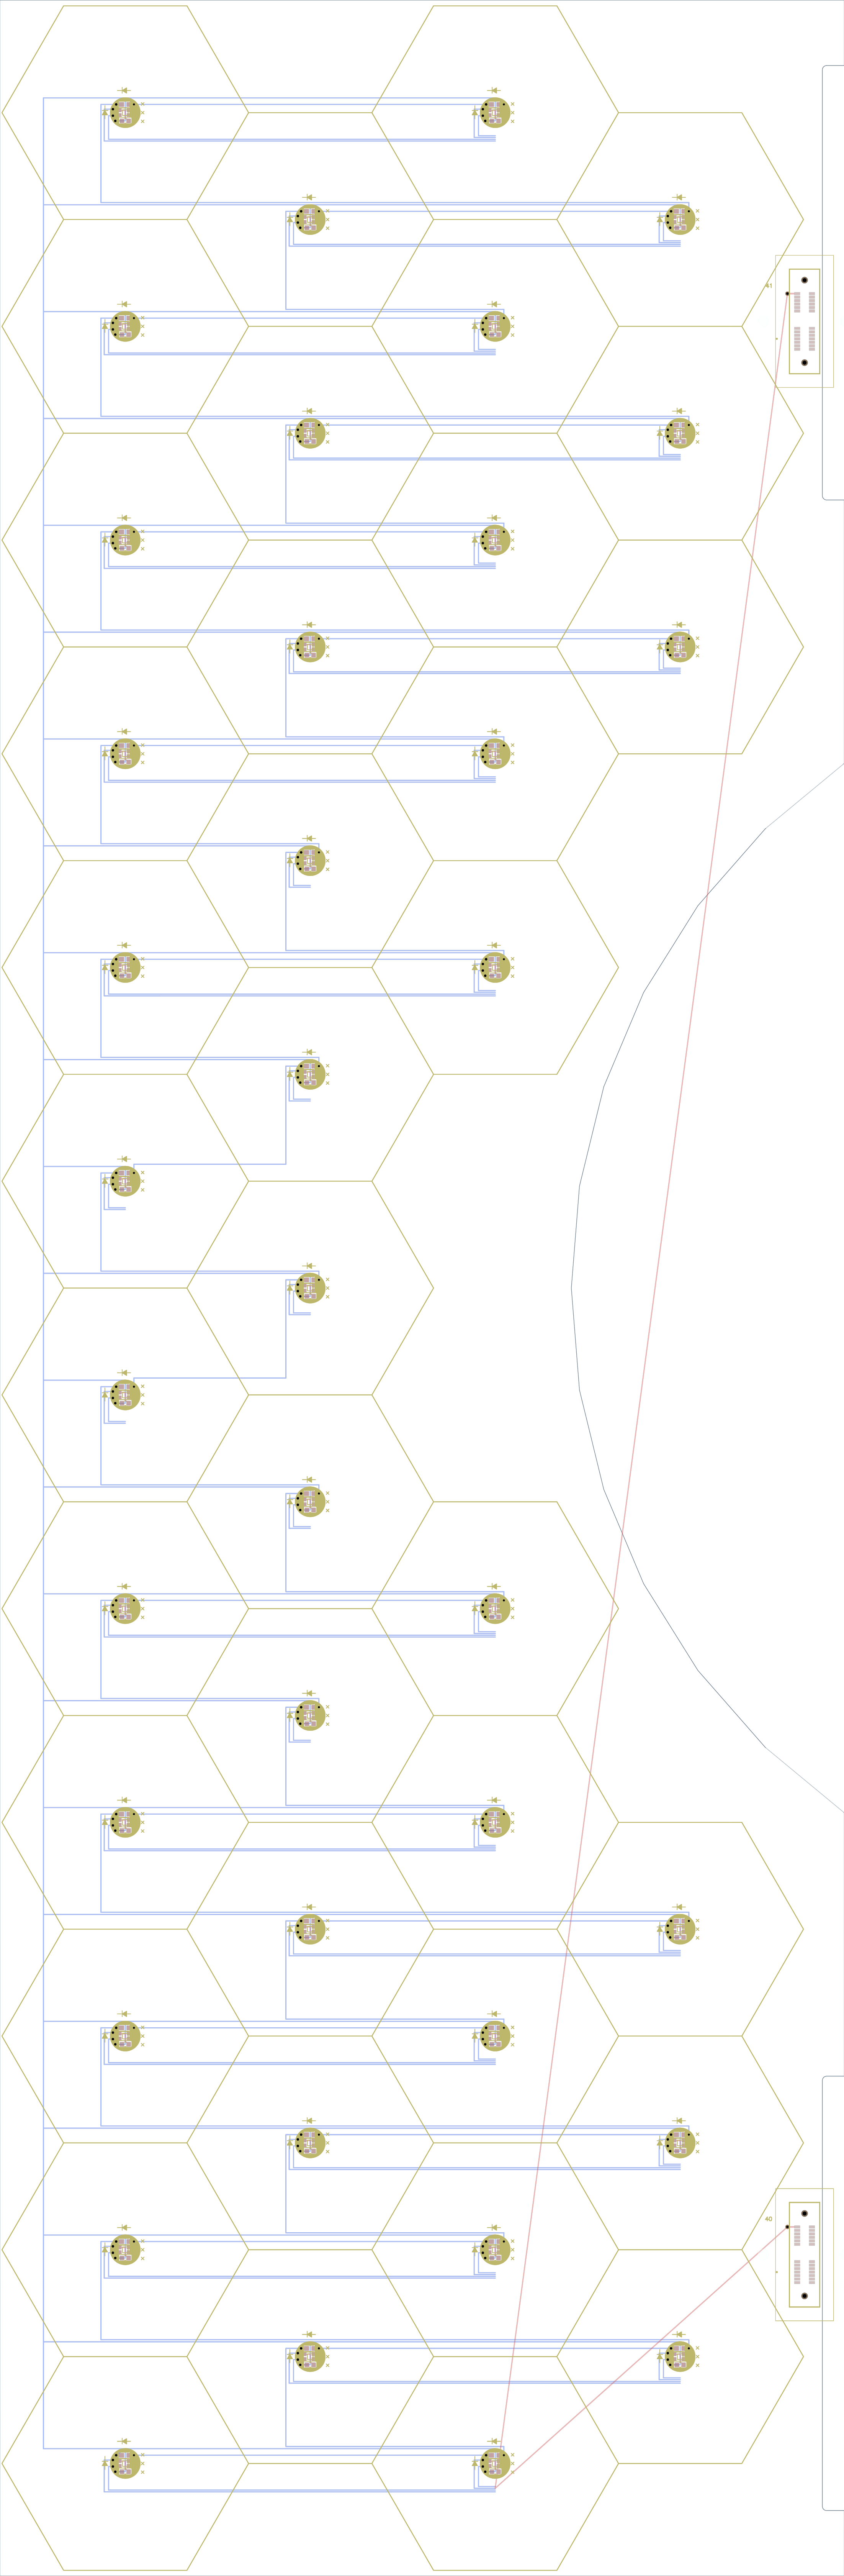

In [223]:
def add_connectors(brd, layer, side, offset, SiPMs):
    
    for tb in -1,1:
        if side=="L":
            x=-1.1*10-offset[0]
            y=tb*22.25*10-offset[1]
            connector=KiCadPart(brd.DC((x,y),90), libraryfile="footprints/SAMTEC_HSEC8-113-01-X-DV-A-L2.kicad_mod")
            brd.addnet(connector.pads[0], SiPMs[0].pad('"SiPM_C"'))
            connector.fanout(connector.pads[0].name,2)
            connector.pads[0].meet(SiPMs[0].pad('"SiPM_C"'))
# test this method
brd,offset = make_board(21,"L")
SiPMs=add_SiPMs(brd, 21, "L", offset)
add_connectors(brd, 21, "L", offset, SiPMs)
brd.save("test_connectors")

from wand.image import Image as WImage
img = WImage(filename='test_connectors/test_connectors_preview_all.pdf')
img

In [8]:
path = f"pcb_output"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [10]:
for layer in range(1, 60+1):
    for side in "LR":
        brd,offset = make_board(layer,side)
        add_SiPMs(brd, layer, side, offset)
        path = f"pcb_output/{layer}{side}"
        # Check whether the specified path exists or not
        isExist = os.path.exists(path)
        if not isExist:
           # Create a new directory because it does not exist
           os.makedirs(path)
        brd.save(path.split('/')[-1], subdir=path.split('/')[0])
        print("done with layer ", layer, "side", side)

Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  1 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering p

Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  7 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  8 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering G

Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  14 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  15 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...


Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  21 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  22 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...


Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  28 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  29 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...


Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  35 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  36 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...


Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  42 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  43 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...


Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  49 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  50 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GB

Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  56 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  57 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GB

In [73]:
help(brd)

Help on Board in module pcbflow.board object:

class Board(builtins.object)
 |  Board(size=(80, 50))
 |  
 |  Methods defined here:
 |  
 |  DC(self, xy, d=0)
 |      Returns a drawing context from the current board.
 |      
 |      :param xy: x, y coordinate tuple
 |      :param d: d direction angle (deg)
 |      
 |      :returns: :obj:`Draw` drawing context object
 |  
 |  __init__(self, size=(80, 50))
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_bitmap(self, xy, fn, scale=None, side='top', layer=None, keepout_box=False, soldermask_box=False)
 |  
 |  add_drill(self, xy, diameter)
 |  
 |  add_hole(self, xy, diameter)
 |  
 |  add_inner_copper_layer(self, layer_count=1)
 |      Adds one or more copper layers between the top and bottom copper layers.
 |      
 |      :param layer_count : Specifies how many copper layers to insert
 |  
 |  add_keepout(self, top_left, bottom_right, layer)
 |  
 |  add_keepout_to_obj(self, obj, layer=None)
 |  
 |

In [29]:
int("acdc",16)

44252